In [1]:
import sklearn
print (sklearn.__version__)

0.19.0


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.model_selection import train_test_split
%matplotlib inline

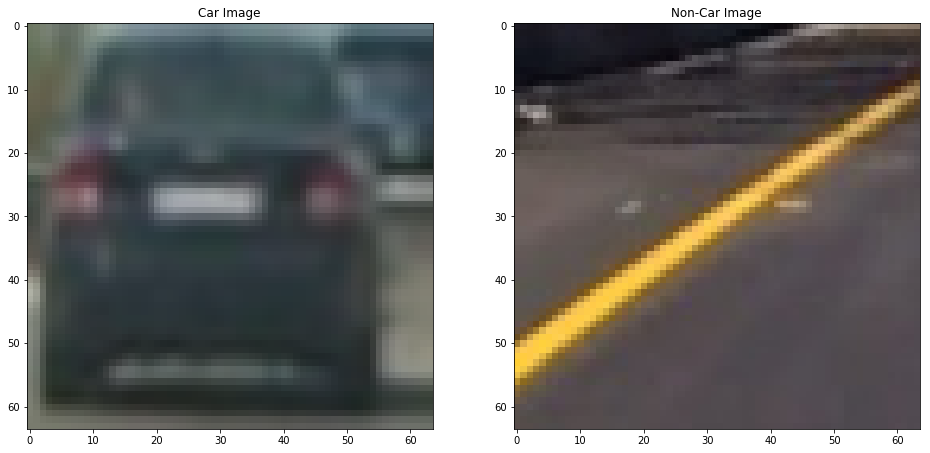

In [3]:
## Reading the data
vehicle_images=glob.glob("vehicles/**/*.png")
cars=[]
notcars=[]
for image in vehicle_images:
    cars.append(image)
img1=plt.imread('vehicles/GTI_MiddleClose/image0000.png')
    
plt.figure(figsize=(16, 12))
plt.subplot(121)
plt.gca().set_title('Car Image')
plt.imshow(img1)

non_vehicle_images=glob.glob("non-vehicles/**/*.png")
for image in non_vehicle_images:
    notcars.append(image)
img2=plt.imread('non-vehicles/Extras/extra27.png')  
plt.subplot(122)
plt.gca().set_title('Non-Car Image')
plt.imshow(img2)
plt.show()

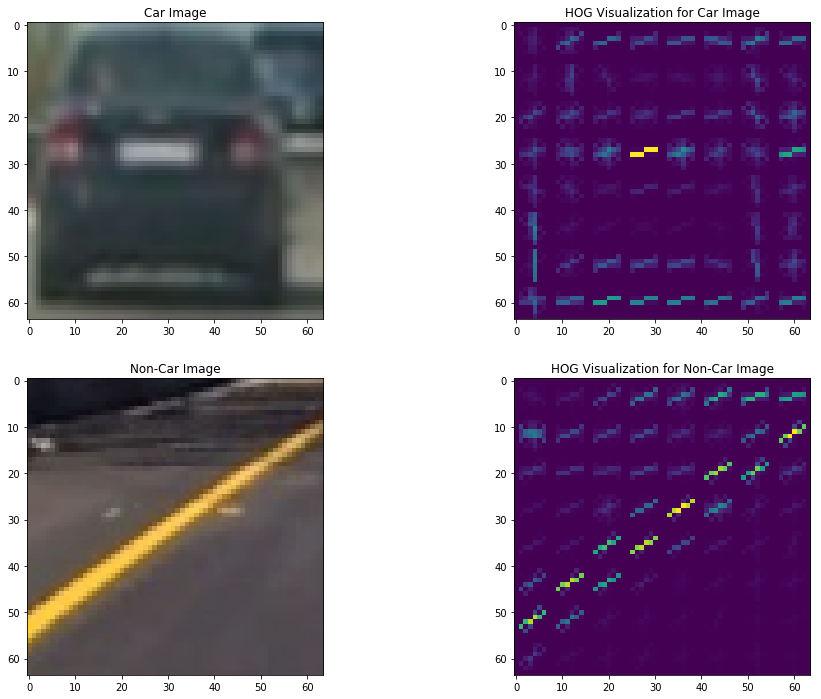

In [4]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 11
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
features1, hog_image1 = hog(gray1, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
plt.figure(figsize=(16, 12))
plt.subplot(221)
plt.gca().set_title('Car Image')
plt.imshow(img1)
plt.subplot(222)
plt.gca().set_title('HOG Visualization for Car Image')
plt.imshow(hog_image1)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
features1, hog_image2 = hog(gray2, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
plt.subplot(223)
plt.gca().set_title('Non-Car Image')
plt.imshow(img2)

plt.subplot(224)
plt.gca().set_title('HOG Visualization for Non-Car Image')
plt.imshow(hog_image2)

plt.show()

In [5]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [12]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [450, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

C:\Users\ramra\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9636
16.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9899


In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def rectpts(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    heatmap=np.zeros_like(img)
    draw_img = np.copy(img)
    bbox_list=[]
    point1=(0,0)
    point2=(0,0)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
#     ctrans_tosearch =img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_features =hog_feat1
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            point1=(xbox_left, ytop_draw+ystart)
            point2=(xbox_left+win_draw,ytop_draw+win_draw+ystart)
            points=(xbox_left, ytop_draw+ystart,xbox_left+win_draw,ytop_draw+win_draw+ystart)
#                 points=(point1,point2)
            bbox_list.append(points)
    return bbox_list

In [39]:
def drawboxes(bbox_list,img):
    imgcpy=np.copy(img)
    i=0
    for box in bbox_list:
        if i%2==0:
            cv2.rectangle(img, (box[0],box[1]), (box[2],box[3]), (0,0,255), 6)
        else:
            cv2.rectangle(img, (box[0],box[1]), (box[2],box[3]), (0,255,255), 6)
            
        i=i+1
    return img

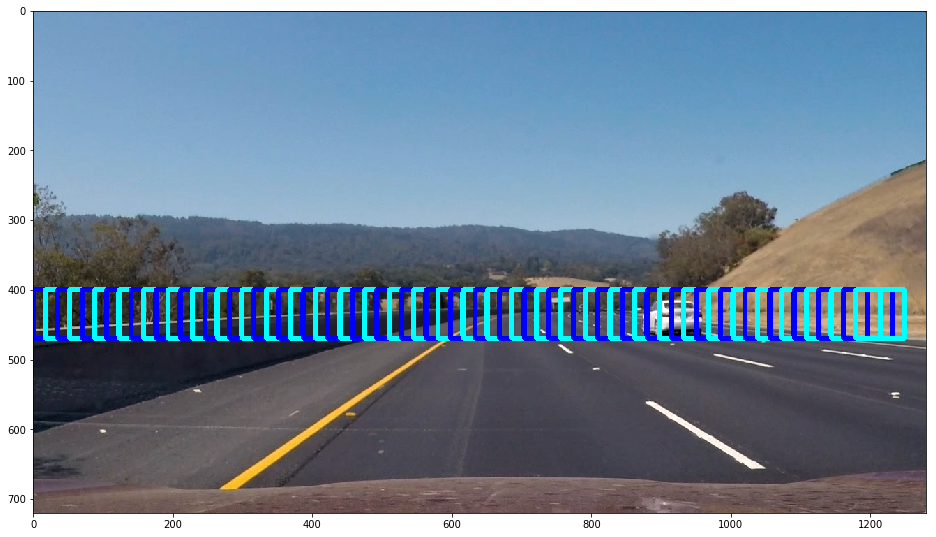

In [50]:
ystart0=400
ystop0=500
scale0=1.1
imgsc1=mpimg.imread('test_images/test3.jpg')
points=rectpts(imgsc1, ystart0, ystop0, scale0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
imgdra=drawboxes(points,imgsc1)
plt.figure(figsize=(16, 12))
plt.imshow(imgdra)

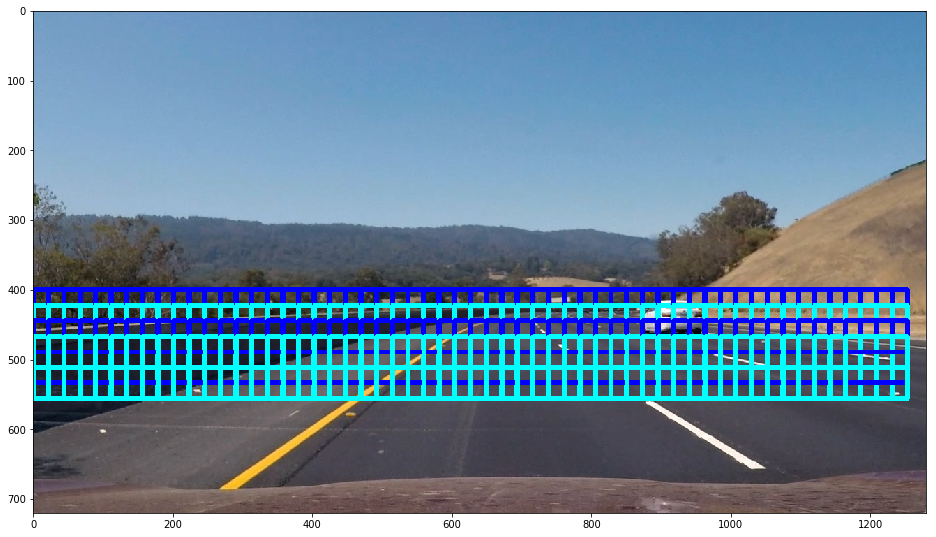

In [51]:
ystart0=400
ystop0=580
scale0=1.4
imgsc1=mpimg.imread('test_images/test3.jpg')
points=rectpts(imgsc1, ystart0, ystop0, scale0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
imgdra=drawboxes(points,imgsc1)
plt.figure(figsize=(16, 12))
plt.imshow(imgdra)

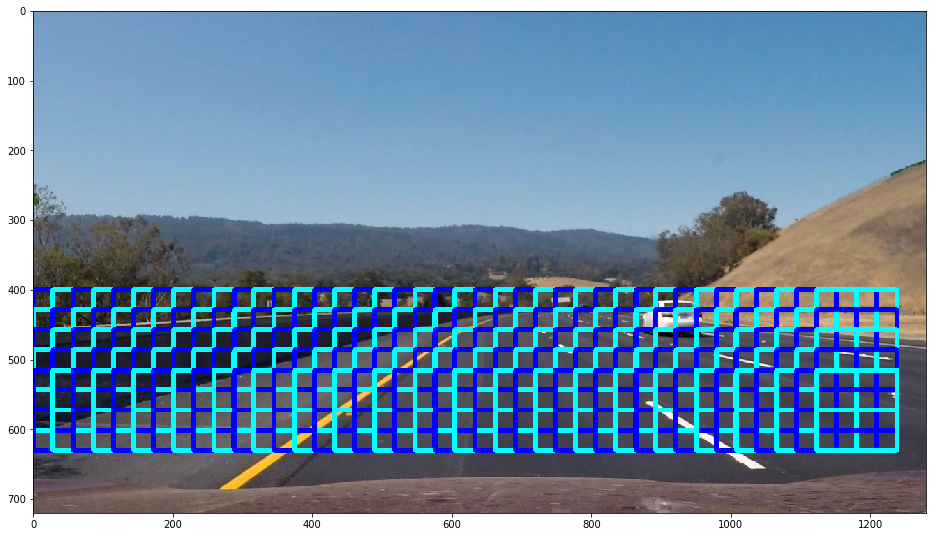

In [52]:
ystart0=400
ystop0=680
scale0=1.8
imgsc1=mpimg.imread('test_images/test3.jpg')
points=rectpts(imgsc1, ystart0, ystop0, scale0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
imgdra=drawboxes(points,imgsc1)
plt.figure(figsize=(16, 12))
plt.imshow(imgdra)

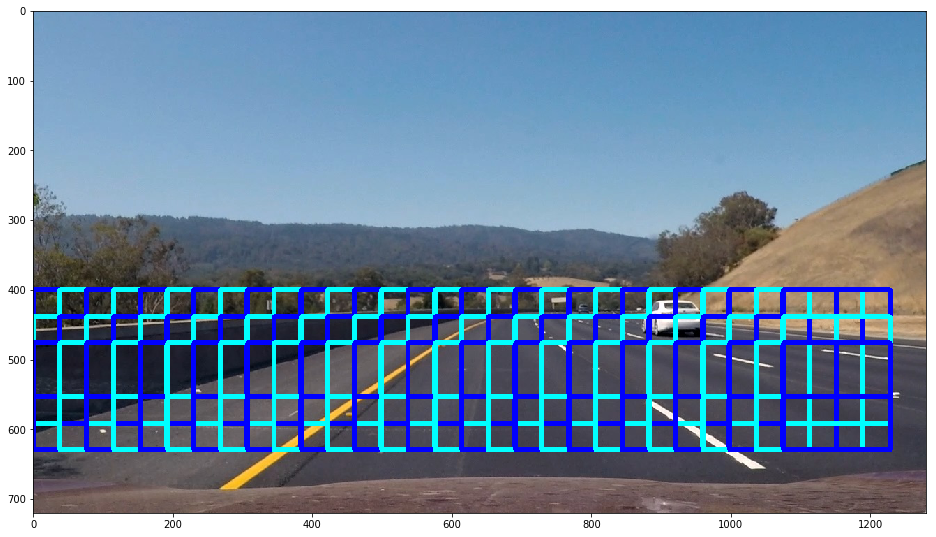

In [53]:
ystart0=400
ystop0=700
scale0=2.4
imgsc1=mpimg.imread('test_images/test3.jpg')
points=rectpts(imgsc1, ystart0, ystop0, scale0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
imgdra=drawboxes(points,imgsc1)
plt.figure(figsize=(16, 12))
plt.imshow(imgdra)

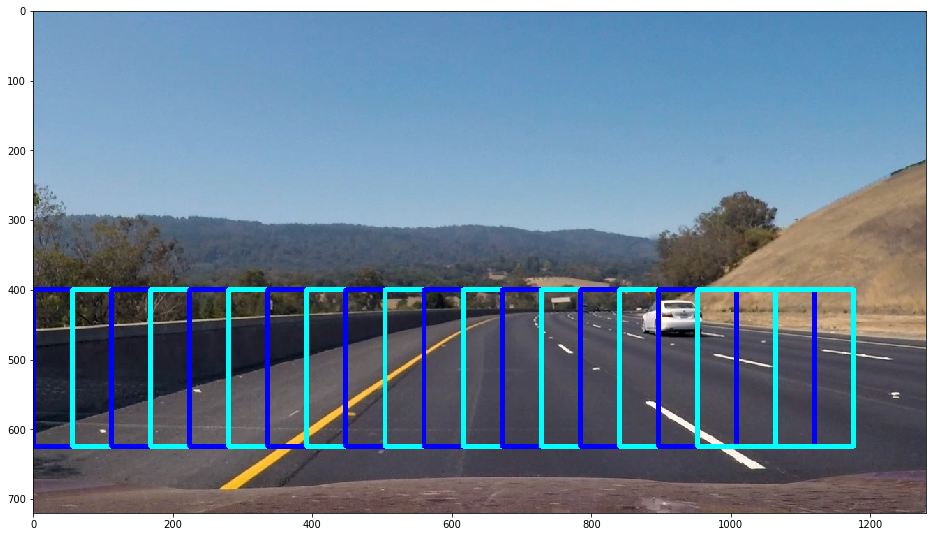

In [54]:
ystart0=400
ystop0=720
scale0=3.5
imgsc1=mpimg.imread('test_images/test3.jpg')
points=rectpts(imgsc1, ystart0, ystop0, scale0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
imgdra=drawboxes(points,imgsc1)
plt.figure(figsize=(16, 12))
plt.imshow(imgdra)

In [55]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#         print(box)
        if abs(box[0]-box[2])<120:
            if box[3]<600:
                heatmap[box[1]:box[3],box[0]:box[2]] += 2
        else: 
            heatmap[box[1]:box[3],box[0]:box[2]] += 1

    # Return updated heatmap
    return heatmap

In [93]:
def add_heat1(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        if abs(box[0]-box[2])<120:
            if box[3]<600:
                heatmap[box[1]:box[3],box[0]:box[2]] += 2
        else: 
            heatmap[box[1]:box[3],box[0]:box[2]] += 1

    # Return updated heatmap
    return heatmap

In [56]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [57]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [58]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    heatmap=np.zeros_like(img)
    draw_img = np.copy(img)
    bbox_list=[]
    point1=(0,0)
    point2=(0,0)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
#     ctrans_tosearch =img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
#             hog_features =hog_feat1
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                point1=(xbox_left, ytop_draw+ystart)
                point2=(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                points=(xbox_left, ytop_draw+ystart,xbox_left+win_draw,ytop_draw+win_draw+ystart)
#                 points=(point1,point2)
                bbox_list.append(points)
#     bbox_list1=np.array(bbox_list)        
#     heatmap=add_heat(heatmap, bbox_list)
#     heatmap=apply_threshold(heatmap,1)
    return bbox_list
#     return draw_img

In [68]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars1(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    heatmap=np.zeros_like(img)
    draw_img = np.copy(img)
    bbox_list=[]
    point1=(0,0)
    point2=(0,0)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
#     ctrans_tosearch =img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
#             hog_features =hog_feat1
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,255),6) 
                point1=(xbox_left, ytop_draw+ystart)
                point2=(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                points=(xbox_left, ytop_draw+ystart,xbox_left+win_draw,ytop_draw+win_draw+ystart)
#                 points=(point1,point2)
                bbox_list.append(points)
#     bbox_list1=np.array(bbox_list)        
#     heatmap=add_heat(heatmap, bbox_list)
#     heatmap=apply_threshold(heatmap,1)
    return bbox_list

C:\Users\ramra\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[(1161, 400, 1231, 470), (828, 400, 917, 489), (828, 422, 917, 511), (851, 422, 940, 511), (1052, 400, 1141, 489), (1052, 422, 1141, 511), (1075, 400, 1164, 489), (1120, 422, 1209, 511), (1142, 400, 1231, 489), (1164, 400, 1253, 489), (1164, 422, 1253, 511), (806, 400, 921, 515), (835, 400, 950, 515), (1036, 400, 1151, 515), (1065, 400, 1180, 515), (1123, 400, 1238, 515), (806, 400, 959, 553)]


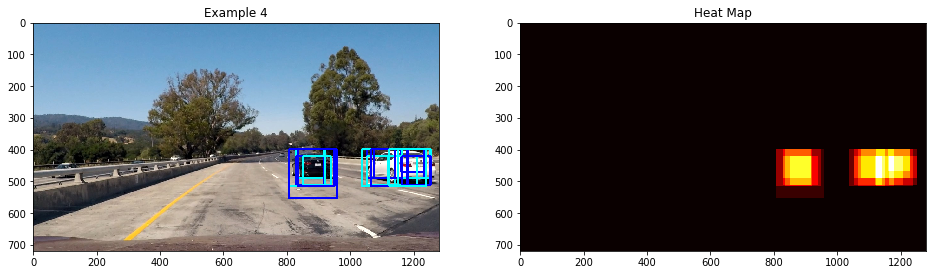

In [114]:
img=mpimg.imread('test_images/test1.jpg')
fin_image=mpimg.imread('test_images/test1.jpg')
imgsc=img/255

imgpoints=[]

ystart0 = 400
ystop0 = 500
scale0 = 1.1


ystart = 400
ystop = 580
scale = 1.4

ystart1=400
ystop1= 680
scale1=1.8

ystart2=400
ystop2=700
scale2=2.4

ystart3=400
ystop3=720
scale3=3.5

point00= find_cars1(imgsc, ystart0, ystop0, scale0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for point in point00:
    imgpoints.append(point)
point01= find_cars(imgsc, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for point in point01:
    imgpoints.append(point)
point02= find_cars(imgsc, ystart1, ystop1, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for point in point02:
    imgpoints.append(point)
point03= find_cars(imgsc, ystart2, ystop2, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for point in point03:
    imgpoints.append(point)
point04= find_cars(imgsc, ystart3, ystop3, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for point in point04:
    imgpoints.append(point)
# plt.imshow(out_img)
print(imgpoints)
imgdra=drawboxes(imgpoints,img)
plt.figure(figsize=(16, 12))
plt.subplot(121)
plt.gca().set_title('Example 4')
plt.imshow(imgdra)
heatmap_image= np.zeros_like(img[:,:,0])
heatmap_image=add_heat1(heatmap_image,imgpoints)
plt.subplot(122)
plt.gca().set_title('Heat Map')
plt.imshow(heatmap_image,cmap='hot')

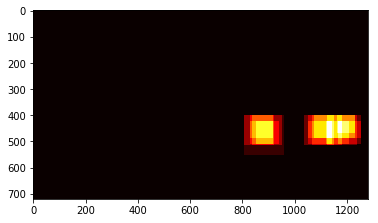

In [115]:
heatmap_image= np.zeros_like(img[:,:,0])
heatmap_image=add_heat1(heatmap_image,imgpoints)
plt.imshow(heatmap_image,cmap='hot')

2 cars found


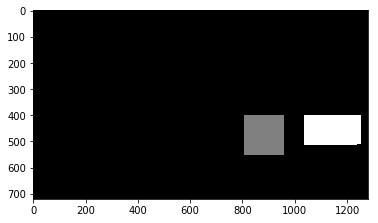

In [117]:
labels = label(heatmap_image)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
final_image=draw_labeled_bboxes(fin_image, labels)
# plt.imshow(final_image)

In [103]:
from scipy.ndimage.measurements import label

cap = cv2.VideoCapture('project_video.mp4')

ystart0=400
ystop0=500
scale0=1.1

ystart = 400
ystop = 580
scale = 1.4

ystart1=400
ystop1= 680
scale1=1.8

ystart2=400
ystop2=700
scale2=2.4

ystart3=400
ystop3=720
scale3=3.5

heatmap= np.zeros_like(img[:,:,0])
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('video.mp4',fourcc,20.0,(1280,720))

i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    img1=frame
    points=[]
#     heatmap=np.zeros_like(img1)
#     heatmap=np.zeros_like(img1)
#     img1 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    imgsc1=img1/255
    point0=find_cars(imgsc1, ystart0, ystop0, scale0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    point1=find_cars(imgsc1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    point2=find_cars(imgsc1, ystart1, ystop1, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    point3=find_cars(imgsc1, ystart2, ystop2, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    point4=find_cars(imgsc1, ystart3, ystop3, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


    for point in point0:
#         cv2.rectangle(frame,(point[0],point[1]),(point[2],point[3]),(255,0,0),6)
        print(point0)
        if point[0]>600:
            points.append(point)
    for point in point1:
#         cv2.rectangle(frame,(point[0],point[1]),(point[2],point[3]),(0,0,255),6)
        points.append(point)
    for point in point2:
#         cv2.rectangle(frame,(point[0],point[1]),(point[2],point[3]),(255,0,255),6)
        points.append(point)
    for point in point3:
#         cv2.rectangle(frame,(point[0],point[1]),(point[2],point[3]),(0,255,0),6)
        points.append(point)
    for point in point4:
#         cv2.rectangle(frame,(point[0],point[1]),(point[2],point[3]),(0,255,0),6)
        points.append(point)
    heatmap=add_heat(heatmap, points)
    heatmap=apply_threshold(heatmap,3)
    labels = label(heatmap)
    image=draw_labeled_bboxes(frame, labels)
#     cv2.imshow('Imag0',imag0)
#     cv2.imshow('Imag1',imag1)
#     cv2.imshow('Imag2',imag2)
#     cv2.imshow('Imag3',imag3)
#     cv2.imshow('Imag4',imag4)
    cv2.imshow('Frame',image)
#     heatmap=np.zeros_like(img1)
    if i>1:
        heatmap=np.zeros_like(img1)
        i=0
    i=i+1
    video.write(frame)
#     print(heatmap)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
video.release()

C:\Users\ramra\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[(1038, 400, 1108, 470)]
[(1056, 400, 1126, 470)]
[(1073, 400, 1143, 470)]
[(1144, 400, 1214, 470)]
[(1161, 400, 1231, 470)]
[(1179, 400, 1249, 470)]
[(158, 400, 228, 470)]
[(70, 400, 140, 470)]
[(35, 400, 105, 470)]
[(17, 400, 87, 470)]
[(158, 400, 228, 470)]
[(105, 400, 175, 470)]
[(88, 400, 158, 470), (968, 400, 1038, 470)]
[(88, 400, 158, 470), (968, 400, 1038, 470)]
[(70, 400, 140, 470)]
[(35, 400, 105, 470), (52, 400, 122, 470), (985, 400, 1055, 470)]
[(35, 400, 105, 470), (52, 400, 122, 470), (985, 400, 1055, 470)]
[(35, 400, 105, 470), (52, 400, 122, 470), (985, 400, 1055, 470)]
[(17, 400, 87, 470), (985, 400, 1055, 470)]
[(17, 400, 87, 470), (985, 400, 1055, 470)]
[(1056, 400, 1126, 470)]
[(1091, 400, 1161, 470)]
[(1126, 400, 1196, 470)]
[(1179, 400, 1249, 470)]
[(1179, 400, 1249, 470)]
[(1179, 400, 1249, 470)]
[(1179, 400, 1249, 470)]
[(1179, 400, 1249, 470)]
[(1179, 400, 1249, 470)]
[(1161, 400, 1231, 470), (1179, 400, 1249, 470)]
[(1161, 400, 1231, 470), (1179, 400, 1249, 4

In [ ]:
heatmap=np.zeros_like(img1)

In [ ]:
video.release()